<a href="https://colab.research.google.com/github/k-washi/3D-BoNet/blob/master/explain/score_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 参考文献
[1] [機械学習モデルの判断根拠の説明](https://www.slideshare.net/SatoshiHara3/ver2-225753735)  
[2] [機械学習の説明可能性](https://tjo.hatenablog.com/entry/2019/12/19/190000)
[3] [Score-CAM](https://github.com/haofanwang/Score-CAM)


@TJO_datasci
>機械学習の説明可能性（解釈性）、大半のケースで求められているのは厳密な分類・回帰根拠ではなく受け手の「納得感」なので、特に実ビジネス上は説明可能性に長けたモデルを開発するより、納得できないお客さんを巧みに関係性構築した上で口八丁で完璧に説得できる凄腕営業ピープルを雇う方が重要

などの意見がある。  
実際の工場などで、製品の外観検査を行い、良品か不良品か判断が必要な場合を考える。人による目視による検査を行ったとしても、AIによる検査を導入したとしても誤りがある。

Andrej Karpathy氏は、[3] [1 smart, trained and highly education human being performed at that error rate](http://karpathy.github.io/2014/09/02/what-i-learned-from-competing-against-a-convnet-on-imagenet/)において、ImageNetデータセットを作成する際、熟練のラベラーでも13〜15%のエラー率であり、Andrej氏が"苦痛を伴う長時間の訓練"を行い、じっくりとアノテーションを行うことで、結果として5.1%のエラー率を達成したと述べている。

どんなに頑張っても、人間のエラーは防げないし、結果的にAIのエラーも防げない。

なら、外観検査に誤りが多かったとしよう。その場合、その原因を調査し、報告書を作成し、改善を行う必要がある。人間による目視検査の場合、人のマインドや集中力を高めることや、「見える化」などの環境改善など、長い歴史のなかで積み重ねられてきた多くの経験的な改善策が挙げられる。一方で、AIによる外観検査のミスは、中身がブラックボックスであることも多く、原因の報告や、改善方法の提案が難しいことが多い。改善策としては、データを増やして性能をあげますとしか言えず、現場を管理する側から考えると納得感が得られないことも多い。

そこで、本記事では、犬と猫の分類を行い、誤分類が発生した時の原因を考える。

データセットは、[cat_vs_dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs)を使用しました。

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
import time
import os
import copy

torch.manual_seed(1234)
np.random.seed(1234)

[4] [TensorFlow, Kerasで転移学習・ファインチューニング（画像分類の例）](https://note.nkmk.me/python-tensorflow-keras-transfer-learning-fine-tuning/)

In [ ]:
download_flag = not os.path.exists("./pet_dataset/images.tar.gz")
if download_flag:
    import tarfile
    import urllib
    os.makedirs('./pet_dataset/', exist_ok=True)
    url = 'http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz'
    urllib.request.urlretrieve(url, './pet_dataset/images.tar.gz')

In [ ]:
!tar -xzf ./pet_dataset/images.tar.gz -C ./pet_dataset/

In [ ]:
#%ls ./pet_dataset/images/
"""
english_setter_9.jpg*               Siamese_206.jpg*
german_shorthaired_100.jpg*         Siamese_207.jpg*
"""

'\nenglish_setter_9.jpg*               Siamese_206.jpg*\ngerman_shorthaired_100.jpg*         Siamese_207.jpg*\n'

In [ ]:
X_file = []
y = []

data_dir = "./pet_dataset/images/"

for fname in os.listdir(data_dir):
    if not fname.endswith('.jpg'):
        continue
    y.append('_'.join(fname.split('_')[:-1]).lower())
    X_file.append(os.path.join(data_dir,fname))


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_file, y, test_size=0.2, stratify=y)

In [ ]:
import shutil
for label in np.unique(y):
    os.makedirs(os.path.join("./pet_dataset/train", label), exist_ok=True)
    os.makedirs(os.path.join("./pet_dataset/val", label), exist_ok=True)
for img_path, label in zip(X_train, y_train):
    shutil.copy(img_path, os.path.join("./pet_dataset/train", label, img_path.split('/')[-1]))
for img_path, label in zip(X_test, y_test):
    shutil.copy(img_path, os.path.join("./pet_dataset/val", label, img_path.split('/')[-1]))

In [ ]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]
#size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(IMG_MEAN, IMG_STD)
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMG_MEAN, IMG_STD)
    ]),
}

root_dir = './pet_dataset/'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(root_dir, x), data_transforms[x]) 
    for x in ['train', 'val']
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=False, num_workers=4)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)



{'train': 5912, 'val': 1478}
['abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [ ]:
# test
batch_iterator = iter(dataloaders["train"])  # イテレータに変換
inputs, labels = next(
    batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([8, 3, 224, 224])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


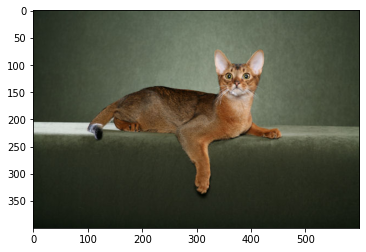

In [ ]:
image_file_path = "./pet_dataset/train/abyssinian/Abyssinian_1.jpg"
img = Image.open(image_file_path)
plt.imshow(img)
plt.show()

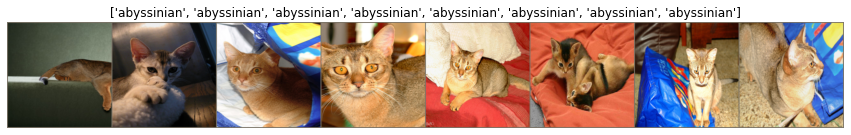

In [ ]:


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMG_MEAN)
    std = np.array(IMG_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # 最小値0, 最大値1でクリップ
    plt.figure(figsize=(15,5))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs, classes = next(iter(dataloaders['train']))
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
net = models.vgg16(pretrained=False)
#net.eval() # 学習させない


In [ ]:
# google drive からweightを読み込み
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp "drive/My Drive/data/fine_tuning_cat_dog.pt" ./

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
net.classifier[6] = nn.Linear(in_features=4096, out_features=len(class_names))
net.to(device)
# 訓練モードに設定
net.load_state_dict(torch.load("./fine_tuning_cat_dog.pt"))
net.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg_model_dict = dict(type='vgg16', layer_name='features_29',input_size=(224, 224))

In [ ]:
def find_vgg_layer(arch, target_layer_name):
    """Find vgg layer to calculate GradCAM and GradCAM++
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_42'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer

In [ ]:
import torch.nn.functional as F
class ScoreCam():
  def __init__(self, model, model_dict):
    
    self.layer_name = model_dict["layer_name"]

    self.arch = model
    self.arch.eval()
    self.arch.cuda()
    
    self.gradients = dict()
    self.activations = dict()

    self.target_layer = find_vgg_layer(self.arch, self.layer_name)

    def backward_hook(module, grad_input, grad_output):    
        self.gradients['value'] = grad_output[0].cuda()   
        return None

    def forward_hook(module, input, output):
        self.activations['value'] = output.cuda()  
        return None
    self.target_layer.register_forward_hook(forward_hook)
    self.target_layer.register_backward_hook(backward_hook)
  
  def forward(self, input):
    c, h, w = input.size() # 1, c, h, w
    
    input_img = input.view(1, c, h, w)
    outputs = self.arch(input_img).cuda()
    logit = F.softmax(outputs)
    predicted_class = outputs.max(1)[-1]
      
    score = outputs[:, outputs.max(1)[-1]].squeeze()
    


    predicted_class = predicted_class.cuda()
    socre = score.cuda()
    smlogit = logit.cuda()

    # featureの最後のrelu部分を取得(特徴マップ)
    self.arch.zero_grad() # 勾配初期化
    score.backward(retain_graph=True) #値が1つでないとエラー
    activations = self.activations["value"]
    b, k, u, v = activations.size()
    activations = activations.cuda()
    score_saliency_map = torch.zeros((1, 1, h, w)).cuda()

    with torch.no_grad():
      for j in range(k):
        saliency_map = torch.unsqueeze(activations[:, j, :, :], 0)
        saliency_map = saliency_map.view(1, 1, u, v)
        saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False) #Dim 4が必要
        if saliency_map.max() == saliency_map.min():
          continue
        norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
          
        sc_output = self.arch(input_img * norm_saliency_map)
        sc_output = F.softmax(sc_output)
        sc_score = sc_output[0][predicted_class]

        score_saliency_map += sc_score * saliency_map

      score_saliency_map = F.relu(score_saliency_map)
      score_saliency_map_min, score_saliency_map_max = score_saliency_map.min(), score_saliency_map.max()

      if score_saliency_map_min == score_saliency_map_max:
        return None

      score_saliency_map = (score_saliency_map - score_saliency_map_min).div(score_saliency_map_max - score_saliency_map_min).data
      
        
    return score_saliency_map
      

  def __call__(self, input):
        return self.forward(input)




In [ ]:
def score_map_show(img, score, save_path="./data.png", text = "", cmap='viridis', alpha=0.7):
    

    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(IMG_MEAN)
    std = np.array(IMG_STD)
    img = std * img + mean
    img = np.clip(img, 0, 1)  # 最小値0, 最大値1でクリップ

    score = score.numpy()[0].transpose((0, 1))
    mean = score.mean()
    std = score.std()
    if std == 0:
      std += 1e-7
    score = (std * score + mean) #* 0.1 
    score += 0.2
    score[score > 1] = 1
    score[score < 0] = 0

    
    subplots = [
        ('Origin', [(img, None, None)]),
        ('Saliency map across RGB channels', [(score, None, None)]),
        ('Overlay', [(img, None, None), (score, cmap, alpha)])
    ]
    num_subplots = len(subplots)
    fig = plt.figure(figsize=(10, 4))

    #print(img.shape, score.shape)
    fig.suptitle(text, fontsize=16)
    
    for i, (title, images) in enumerate(subplots):
        ax = fig.add_subplot(1, num_subplots, i + 1)
        ax.set_axis_off()

        for image, cmap, alpha in images:
            ax.imshow(image, cmap=cmap, alpha=alpha)

    #if save_path is not None:
    #    plt.savefig(save_path)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
def visualize_validation(model, num_images=100):
    vgg_model_dict = dict(type='vgg16', layer_name='features_29',input_size=(224, 224))
    scam = ScoreCam(model, vgg_model_dict)

    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
          outputs = model(inputs)
        outputs = outputs.to("cpu")
        _, preds = torch.max(outputs.data, 1)
        for j in range(inputs.size()[0]):
          if True:
            if preds[j] != labels[j]:
              images_so_far += 1

              ssmap = scam(inputs[j])
              ssmap = ssmap.type(torch.FloatTensor).cpu()
              #print(ssmap.size())

              pred_prob = outputs.data[j]
              pred_prob = np.exp(pred_prob) / np.exp(pred_prob).sum()

              score_map_show(inputs.cpu().data[j], ssmap[0], save_path="./data.png", text = 'answer: {}\npredicted: {}'.format(
                  class_names[labels[j]],class_names[preds[j]]))
              """
              imshow(inputs.cpu().data[j], 'answer: {}\npredicted: {}'.format(
                  class_names[labels[j]],class_names[preds[j]]))
              """

              if images_so_far == num_images:
                  return

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<Figure size 432x288 with 0 Axes>

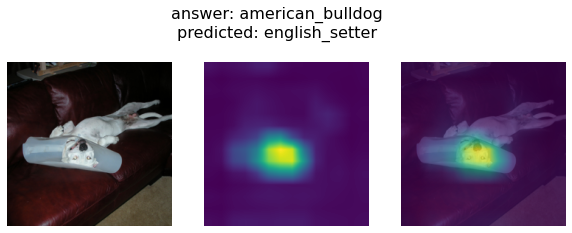

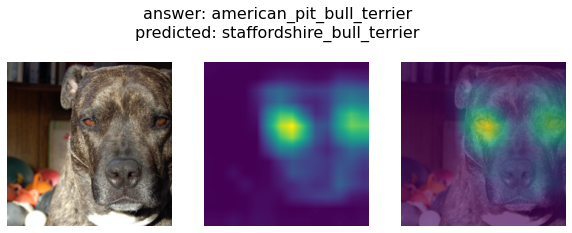

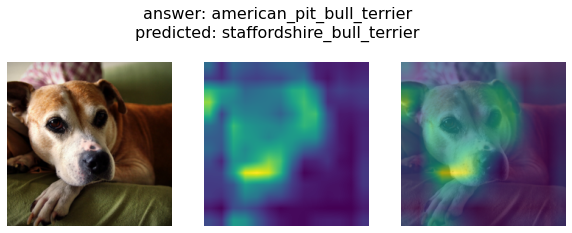

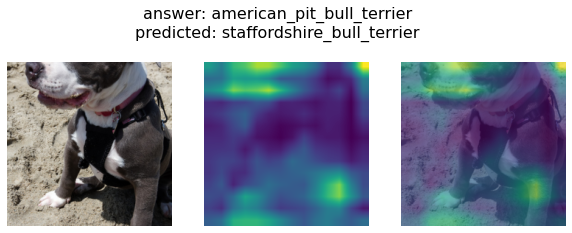

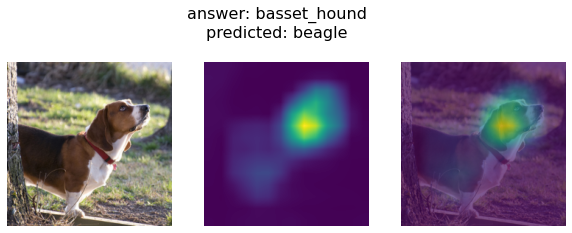

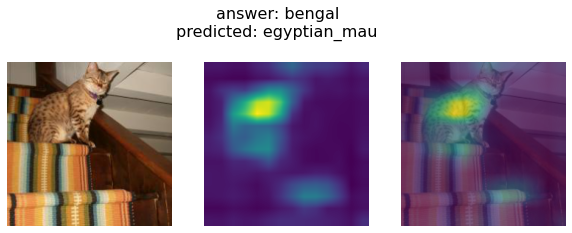

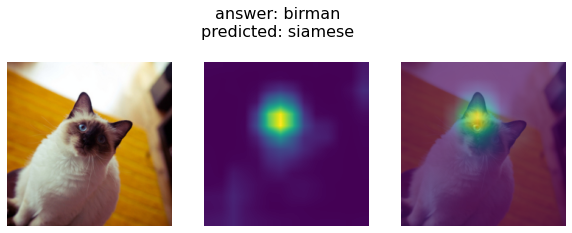

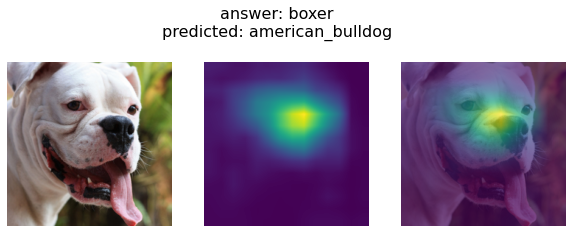

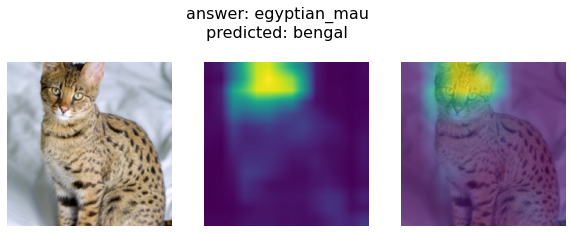

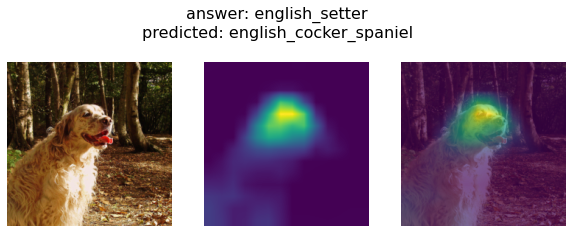

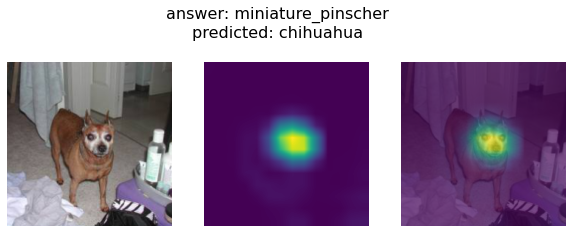

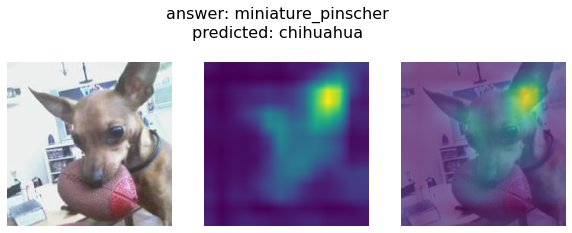

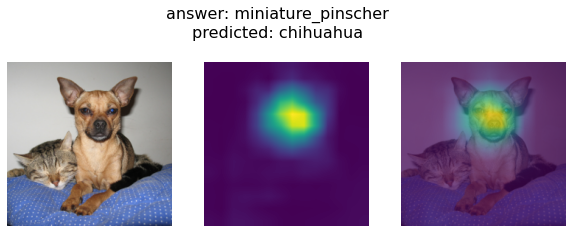

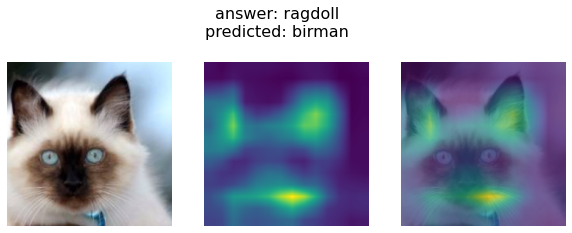

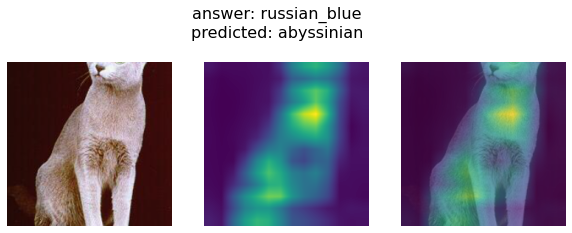

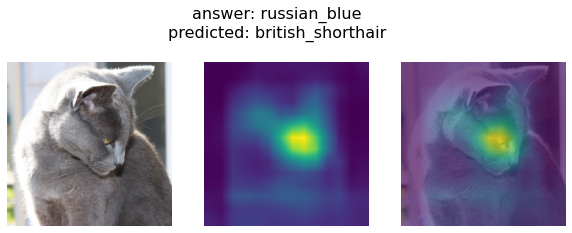

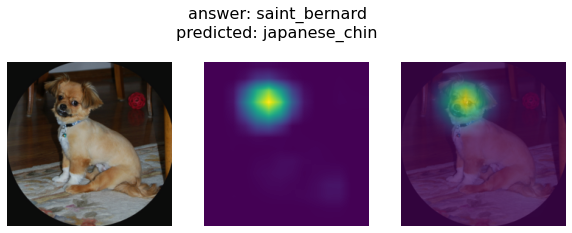

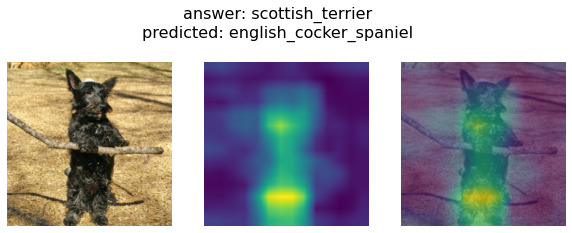

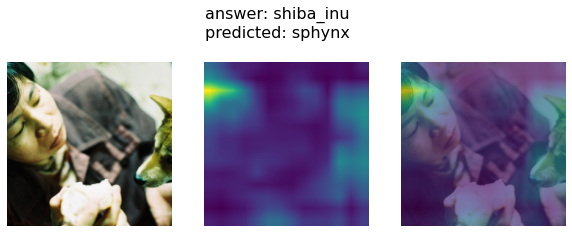

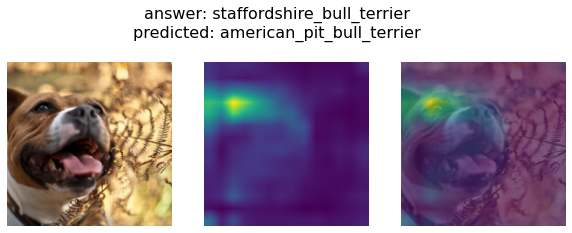

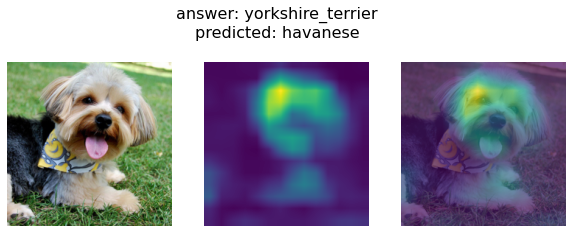

In [ ]:
visualize_validation(net)